In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.iolib.table import SimpleTable

import scipy.stats as scs
from scipy.optimize import minimize

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import ml_metrics as metrics

pd.options.display.float_format = '{:,.15f}'.format
%matplotlib inline

In [2]:
def log_progress(sequence, every=None, size=None, name='Items'): # функция для отслеживания процесса
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [3]:
def test_adfuller(df):
    test = sm.tsa.adfuller(df)
    print('adf:', test[0])
    print('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0] > test[4]['5%']: 
        print('есть единичные корни, ряд не стационарен')
    else:
        print('единичных корней нет, ряд стационарен')

In [4]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh'): #функция для отрисовки графиков 
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        test_adfuller(y)

        plt.tight_layout()
    return 

In [5]:
df = pd.read_csv('Data for Forecast.csv', decimal=",")
df.head()

,Year,Month,Sales
0,2009,1,44265939.13
1,2009,3,54900710.11
2,2009,2,55917784.58
3,2009,4,59119663.88
4,2009,5,60949016.31


In [6]:
df['Date'] = pd.period_range(start='2009-01', end='2019-12', freq='M')
df.index = df['Date']
df = df.drop(['Year', 'Month', 'Date'], axis=1)
df.Sales = df.Sales.astype('float64') 
df.head()

,Sales
Date,
2009-01,"44,265,939.130000002682209"
2009-02,"54,900,710.109999999403954"
2009-03,"55,917,784.579999998211861"
2009-04,"59,119,663.880000002682209"
2009-05,"60,949,016.310000002384186"


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 132 entries, 2009-01 to 2019-12
Freq: M
Data columns (total 1 columns):
Sales    132 non-null float64
dtypes: float64(1)
memory usage: 2.1 KB


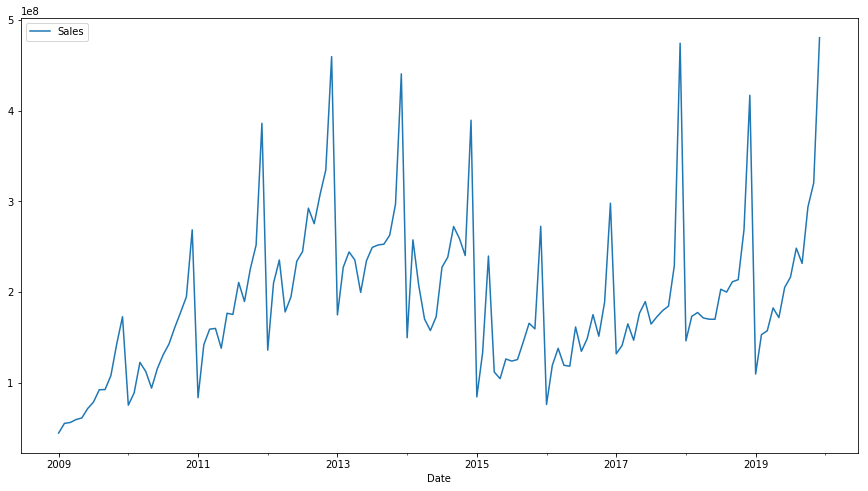

In [8]:
df.plot(figsize=(15,8));

,Sales
count,132.000000000000000
mean,"190,722,379.198787808418274"
std,"85,467,561.132357880473137"
min,"44,265,939.130000002682209"
25%,"137,215,285.200000017881393"
50%,"174,771,993.099999994039536"
75%,"235,165,491.150000005960464"
max,"480,480,288.990000009536743"


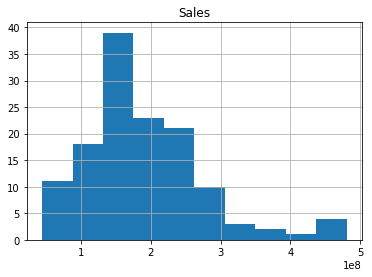

In [9]:
descr = df.describe()
df.hist()
descr

Из характеристик набора данных и гистограммы, делаем вывод о том что ряд более менее однородны и имеет относительно небольшой разброс.

Рассчитаем коэффициент вариации:

In [10]:
print('V = %f' % (descr.loc['std']/descr.loc['mean']))

V = 0.448125


In [11]:
row = [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(df)
a = np.vstack([jb_test])
itog = pd.DataFrame(a,index=row)
itog

,0
JB,47.710396072201974
p-value,0.000000000043633
skew,1.143783799220853
kurtosis,4.855168981584354


Гипотеза о нормальности распределения отвергается с малой вероятностью (probably -> 0.00), и, следовательно, наш ряд имеет нормальное распределение.

Для проверки проверки стационарности давайте проведем обобщенный тест Дикки-Фуллера на наличие единичных корней.

In [12]:
test_adfuller(df.Sales)

adf: -2.1023651178468654
p-value:  0.2435646398786765
Critical values:  {'1%': -3.4870216863700767, '5%': -2.8863625166643136, '10%': -2.580009026141913}
есть единичные корни, ряд не стационарен


Попробуем стабилизировать дисперсию преоразованием Бокса-Кокса.

adf: -2.2886237037671293
p-value:  0.17566330855411416
Critical values:  {'1%': -3.4870216863700767, '5%': -2.8863625166643136, '10%': -2.580009026141913}
есть единичные корни, ряд не стационарен
Оптимальный параметр преобразования Бокса-Кокса: 0.250366


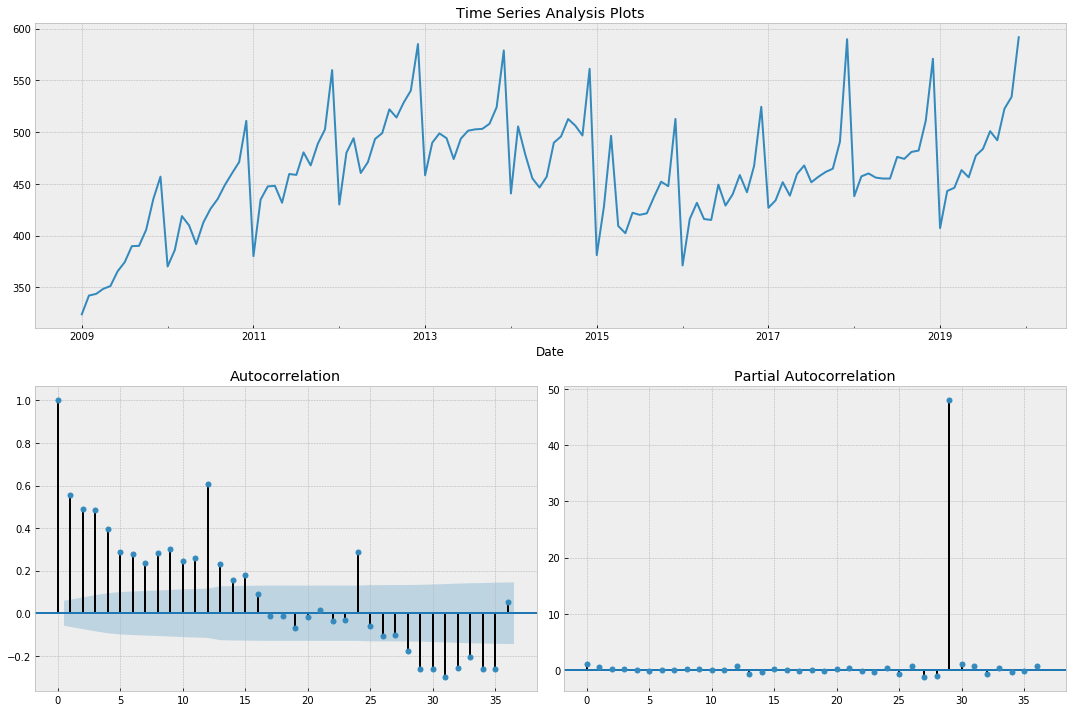

In [13]:
def invboxcox(y,lmbda):
    # обрабтное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

data = df.copy()
data['Sales_box'], lmbda = scs.boxcox(df.Sales)

tsplot(data.Sales_box, lags=36)

print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Критерий Дики-Фуллера не отвергает гипотезу о нестационарности ряда. А автокорреляционная функция показывает на сезонность в получившемся ряде. Возьмём сезонные разности:

adf: -1.8253711221948834
p-value:  0.3679403564529991
Critical values:  {'1%': -3.492995948509562, '5%': -2.888954648057252, '10%': -2.58139291903223}
есть единичные корни, ряд не стационарен


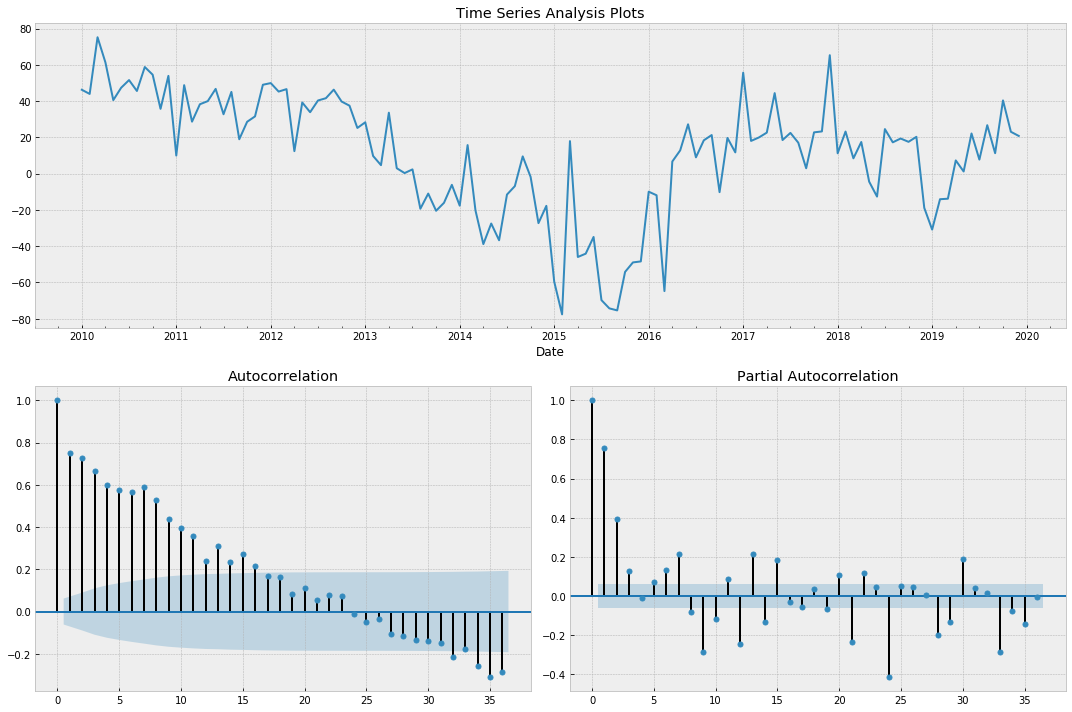

In [14]:
data['Sales_box_season'] = data.Sales_box.diff(periods=12).dropna()
tsplot(data.Sales_box_season[12:], lags=36)

Критерий Дики-Фуллера не отвергает нулевую гипотезу о нестационарности и автокорреляционная функция всё ещё выглядит нехорошо из-за большого числа значимых лагов. Возьмем первые разности, чтобы привести наконец ряд к стационарному виду.

adf: -3.9611258864223706
p-value:  0.0016283201720613022
Critical values:  {'1%': -3.4961490537199116, '5%': -2.8903209639580556, '10%': -2.5821223452518263}
единичных корней нет, ряд стационарен


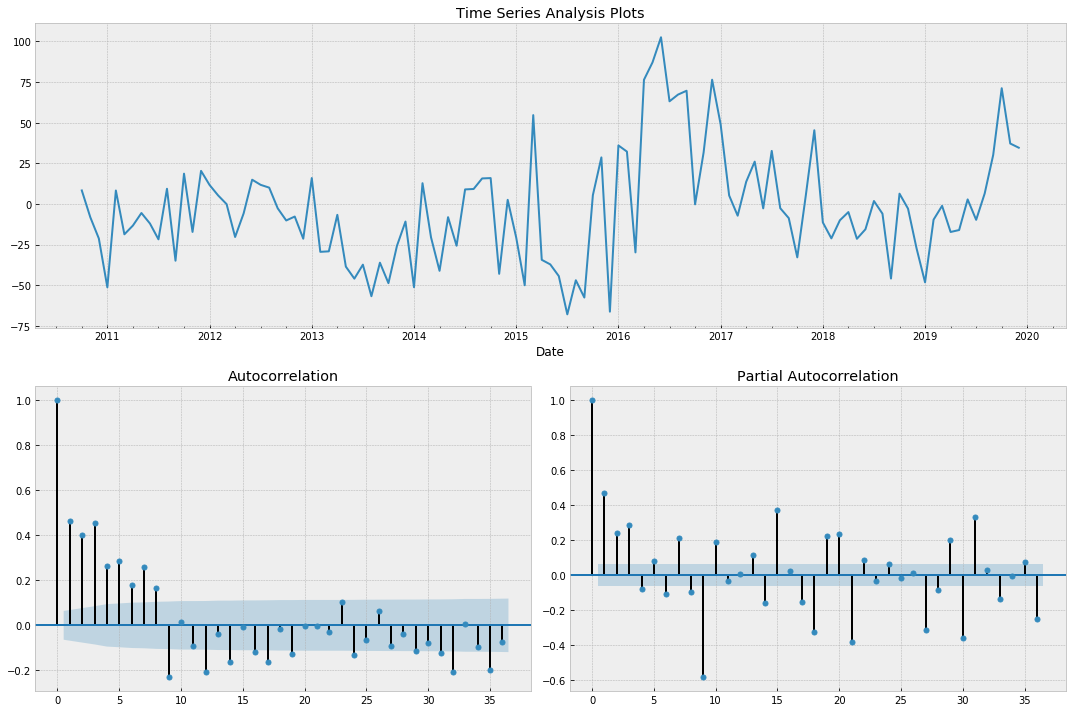

In [15]:
data['Sales_box_season_diff'] = (data.Sales_box_season - data.Sales_box_season.shift(9))
tsplot(data.Sales_box_season_diff[12+9:], lags=36)

Теперь мы получили стационарный ряд, по автокорреляционной и частной автокорреляционной функции прикинем параметры для SARIMA модели, на забыв, что предварительно уже сделали первые и сезонные разности.

Q = 2, P = 1, q = 9, p = 6

In [16]:
ps = range(0, 6)
d=2
qs = range(0, 9)
Ps = range(0, 1)
D=2
Qs = range(0, 2)

from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

108

Обучать модель будем на части выборки, чтобы потом сравнить предсказанные значения и реальные данные.

In [17]:
train = data[:120]
train.tail()

,Sales,Sales_box,Sales_box_season,Sales_box_season_diff
Date,,,,
2018-08,"199,774,030.800000011920929",474.192388431466213,17.260215252839316,-6.018111345256386
2018-09,"211,153,607.500000000000000",480.871055679791198,19.368725897408979,-45.939128589122845
2018-10,"213,467,878.000000000000000",482.196115737336811,17.536533752039531,6.317379798830700
2018-11,"268,761,114.000000000000000",511.058167867948669,20.299794614024677,-2.901392146738374
2018-12,"416,942,634.500000000000000",570.914195204496423,-18.878282201903062,-27.323096985960433


In [18]:
%%time
results = []
best_aic = float("inf")

for param in log_progress(parameters_list, every=5):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(train.Sales_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit()
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

C:\Users\Nataly\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Nataly\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Nataly\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Nataly\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Nataly\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:512: Con

C:\Users\Nataly\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Nataly\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Nataly\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Nataly\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Nataly\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:512: Con

      parameters                 aic
5   (0, 2, 0, 1) 886.489422151606277
45  (2, 4, 0, 1) 888.347266109476209
7   (0, 3, 0, 1) 888.479216620096281
23  (1, 2, 0, 1) 888.507464027281230
25  (1, 3, 0, 1) 889.275458840213901
Wall time: 5min 14s


In [19]:
%%time
best_model = sm.tsa.statespace.SARIMAX(train.Sales_box, order=(2, d, 4), 
                                        seasonal_order=(0, D, 1, 12)).fit(disp=0)
print(best_model.summary())

C:\Users\Nataly\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\statespace\sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Nataly\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\statespace\sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\Nataly\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                          Sales_box   No. Observations:                  120
Model:             SARIMAX(2, 2, 4)x(0, 2, 1, 12)   Log Likelihood                -436.174
Date:                            Fri, 24 Jan 2020   AIC                            888.347
Time:                                    02:13:27   BIC                            908.694
Sample:                                01-31-2009   HQIC                           896.566
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.9037      0.050    -38.060      0.000      -2.002      -1.806
ar.L2         -0.9509      0.049   

adf: -3.400195493734735
p-value:  0.01095220904579727
Critical values:  {'1%': -3.5011373281819504, '5%': -2.8924800524857854, '10%': -2.5832749307479226}
единичных корней нет, ряд стационарен


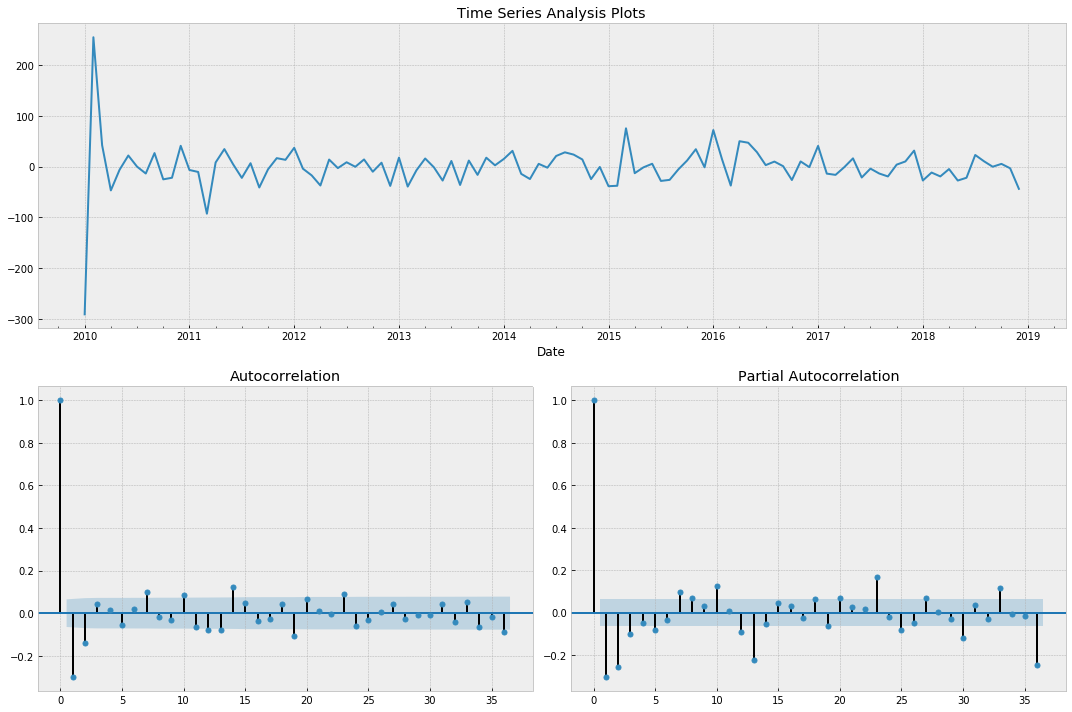

In [20]:
tsplot(best_model.resid[12:], lags=36)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


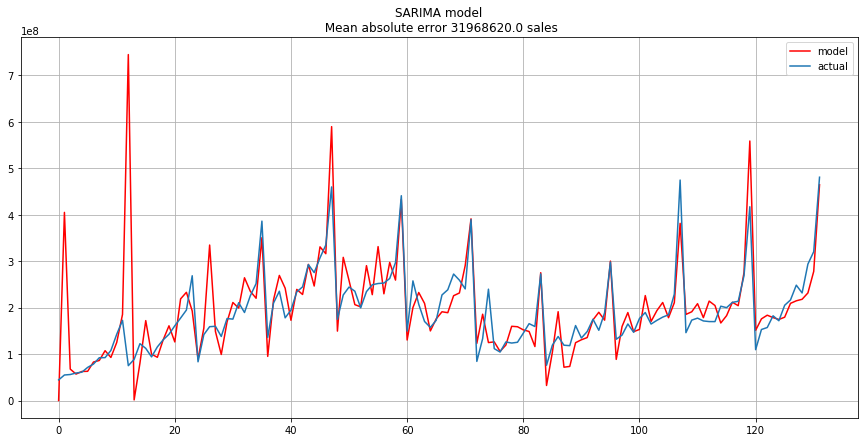

In [21]:
train["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)
forecast = invboxcox(best_model.predict(start = train.shape[0], end = train.shape[0]+11), lmbda)
forecast = train.arima_model.append(forecast).values
actual = df.Sales.values
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
plt.title("SARIMA model\n Mean absolute error {} sales".format(round(mean_absolute_error(train.dropna().Sales, train.dropna().arima_model))))
plt.plot(actual, label="actual")
plt.legend()
plt.grid(True)

In [22]:
df['prediction'] = forecast
df.tail(12)

,Sales,prediction
Date,,
2019-01,"109,353,816.799999997019768","150,952,075.318995743989944"
2019-02,"152,793,682.699999988079071","175,669,746.403851777315140"
2019-03,"157,069,684.099999994039536","183,569,770.645706772804260"
2019-04,"182,286,479.300000011920929","178,390,506.817537903785706"
2019-05,"171,614,055.599999994039536","174,401,098.263114422559738"
2019-06,"204,945,627.599999994039536","179,251,049.129282057285309"
2019-07,"216,314,204.599999994039536","209,035,309.664558708667755"
2019-08,"248,216,187.199999988079071","214,537,868.648242652416229"
2019-09,"231,453,825.800000011920929","217,822,308.633432805538177"


In [24]:
metrics.rmse(df.Sales, df.prediction) #Среднеквадратичное отклонение модели

77420352.34645621

In [25]:
metrics.mae(df.Sales, df.prediction) #Средняя абсолютная ошибка прогноза

37059641.583153196

In [26]:
df.describe()

,Sales,prediction
count,132.000000000000000,132.000000000000000
mean,"190,722,379.198787808418274","199,568,635.209706574678421"
std,"85,467,561.132357880473137","106,114,768.116467386484146"
min,"44,265,939.130000002682209",1.000000000000000
25%,"137,215,285.200000017881393","134,251,681.144426912069321"
50%,"174,771,993.099999994039536","187,306,783.069314301013947"
75%,"235,165,491.150000005960464","231,403,377.936987519264221"
max,"480,480,288.990000009536743","744,384,727.885708332061768"
